# Lyric Mood Classification - Word Embeddings

Steps:

1. Build vocabulary from _full_ set of song lyrics (including those without labels). Save vocabulary as 

word2vec
* skip-gram
* cbow

In [1]:
import os
from index_lyrics import read_file_contents
import collections
import time
import pandas as pd
import numpy as np
import string
import random
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

import math

# NLTK materials - make sure that you have stopwords and punkt for some reason
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords

lyrics_dir_root = 'data/lyrics/txt'
log_dir = 'logs/tf'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jcworkma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jcworkma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## How many unique words do we have?

In [2]:
start = time.time()

unique_words = collections.defaultdict(lambda: 0)
lyricfiles = os.listdir(lyrics_dir_root)
num_files = len(lyricfiles)
contents_processed = 0
for count, lyricfile in enumerate(lyricfiles):
    lyricfile = os.path.join(lyrics_dir_root, lyricfile)
    if count % 10000 == 0:
        print('{0}/{1} lyric files processed. {2:.02f} minutes elapsed. {3} contents processed. {4} unique words acquired.'.format(
            count, num_files, (time.time() - start) / 60, contents_processed, len(unique_words)))
    contents = read_file_contents(lyricfile)
    if contents and contents[0]:
        split = contents[0].split()
        for word in split:
            unique_words[word] += 1
        contents_processed += 1
            
end = time.time()
elapsed = (end - start) / 60

print('Elapsed Time: {0} minutes.'.format(elapsed))

0/294299 lyric files processed. 0.00 minutes elapsed. 0 contents processed. 0 unique words acquired.
10000/294299 lyric files processed. 0.01 minutes elapsed. 9547 contents processed. 122479 unique words acquired.
20000/294299 lyric files processed. 0.02 minutes elapsed. 19145 contents processed. 195130 unique words acquired.
30000/294299 lyric files processed. 0.03 minutes elapsed. 28736 contents processed. 257393 unique words acquired.
40000/294299 lyric files processed. 0.04 minutes elapsed. 38320 contents processed. 308552 unique words acquired.
50000/294299 lyric files processed. 0.05 minutes elapsed. 47911 contents processed. 357693 unique words acquired.
60000/294299 lyric files processed. 0.06 minutes elapsed. 57519 contents processed. 402886 unique words acquired.
70000/294299 lyric files processed. 0.07 minutes elapsed. 67117 contents processed. 446049 unique words acquired.
80000/294299 lyric files processed. 0.08 minutes elapsed. 76664 contents processed. 484761 unique word

In [3]:
df = pd.DataFrame.from_dict(unique_words, orient='index', columns=['count'])
df = df.sort_values('count', ascending=False)
df[:20]

,count
the,1888745
I,1607271
you,1313028
to,1119509
a,1003483
me,748343
and,704609
my,614638
in,613737
of,582333


# TensorFlow Word2vec
Sources:
* http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/
* https://www.tensorflow.org/tutorials/representation/word2vec
* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

Steps:

1. Build a list containing all words in the dataset
2. "Extract the top V most common words to include in our embedding vector"
3. "Gather together all the unique words and index them with a unique integer value – this is what is required to create an equivalent one-hot type input for the word.  We’ll use a dictionary to do this"
4. "Loop through every word in the dataset (vocabulary variable) and assign it to the unique integer word identified, created in Step 2 above.  This will allow easy lookup / processing of the word data stream"

In [4]:
def lyrics_preprocessing(lyrics):
    """
    Apply this function to any lyric file contents before reading for embeddings
    """
    # https://stackoverflow.com/questions/17390326/getting-rid-of-stop-words-and-document-tokenization-using-nltk
    stop = stopwords.words('english') + list(string.punctuation)
    tokens = [i for i in word_tokenize(lyrics.lower()) if i not in stop]
    return tokens

def extract_words(root_dir, preprocessing_func, verbose=True):
    """
    Iterates over all files in <root_dir>, reads contents, applies
    <preprocessing_func> on text, and returns a python list of all words
    """
    start = time.time()

    words = list()
    lyricfiles = os.listdir(lyrics_dir_root)
    num_files = len(lyricfiles)
    contents_processed = 0
    for count, lyricfile in enumerate(lyricfiles):
        lyricfile = os.path.join(lyrics_dir_root, lyricfile)
        if count % 10000 == 0 and verbose:
            print('{0}/{1} lyric files processed. {2:.02f} minutes elapsed. {3} contents processed. {4} words acquired.'.format(
                count, num_files, (time.time() - start) / 60, contents_processed, len(words)))
        contents = read_file_contents(lyricfile)
        if contents and contents[0]:
            tokens = preprocessing_func(contents[0])
            words += tokens
            contents_processed += 1

    end = time.time()
    elapsed = (end - start) / 60

    if verbose:
        print('Elapsed Time: {0} minutes.'.format(elapsed))

    return words

In [5]:
words = extract_words(lyrics_dir_root, lyrics_preprocessing)

0/294299 lyric files processed. 0.00 minutes elapsed. 0 contents processed. 0 words acquired.
10000/294299 lyric files processed. 0.20 minutes elapsed. 9547 contents processed. 1259791 words acquired.
20000/294299 lyric files processed. 0.39 minutes elapsed. 19145 contents processed. 2515120 words acquired.
30000/294299 lyric files processed. 0.59 minutes elapsed. 28736 contents processed. 3779741 words acquired.
40000/294299 lyric files processed. 0.78 minutes elapsed. 38320 contents processed. 5016148 words acquired.
50000/294299 lyric files processed. 0.97 minutes elapsed. 47911 contents processed. 6281925 words acquired.
60000/294299 lyric files processed. 1.17 minutes elapsed. 57519 contents processed. 7538992 words acquired.
70000/294299 lyric files processed. 1.36 minutes elapsed. 67117 contents processed. 8816560 words acquired.
80000/294299 lyric files processed. 1.55 minutes elapsed. 76664 contents processed. 10063517 words acquired.
90000/294299 lyric files processed. 1.75 m

In [12]:
# thank you: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data_index = 0
# generate batch data
def generate_batch(data, batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            context[i * num_skips + j, 0] = buffer[target]  # these are the context words
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, context


In [13]:
V = 50000
data, count, dictionary, reverse_dictionary = build_dataset(words, V)

In [14]:
# memory footprint is probably getting pretty large...
# remove unneeded 'words'
# del words

In [15]:
batch_size = len(os.listdir(lyrics_dir_root))  # rough approximation of appropriate number of batches
batch_size = batch_size - 1 if batch_size % 2 != 0 else batch_size
print('batch_size =', batch_size)
num_skips = 2  # How many times to reuse an input to generate a label.
skip_window = 4  # take 4 before and 4 after for context window

batch_size = 294298


In [16]:
batch, labels = generate_batch(data, batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])
print(len(batch))
print(len(labels))

15 've -> 893 taken
15 've -> 1 's
147 wrong -> 249 today
147 wrong -> 70 long
17 see -> 74 find
17 see -> 15 've
68 'd -> 2815 surprised
68 'd -> 17 see
294298
294298


In [17]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

    # Input data.
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([V, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [V, embedding_size],
                stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
        nce_biases = tf.Variable(tf.zeros([V]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=V))

    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()
    

# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # Open a writer to write summaries.
    writer = tf.summary.FileWriter(log_dir, session.graph)

    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(data, batch_size, num_skips,
                                                skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
        # Feed metadata variable to session for visualizing the graph in TensorBoard.
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        average_loss += loss_val

        # Add returned summaries to writer in each step.
        writer.add_summary(summary, step)
        # Add metadata to visualize the graph for the last run.
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    
    final_embeddings = normalized_embeddings.eval()

    # Write corresponding labels for the embeddings.
    with open(log_dir + '/metadata.tsv', 'w') as f:
        for i in range(V):
            f.write(reverse_dictionary[i] + '\n')

    # Save the model for checkpoints.
    saver.save(session, os.path.join(log_dir, 'model.ckpt'))

    # Create a configuration for visualizing embeddings with the labels in TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)

writer.close()


Initialized
Average loss at step  0 :  269.9797668457031
Nearest to 2: 5-2, sufficient, caduto, lacerated, guarda, doua, euh, whodini,
Nearest to feel: infestation, gluttony, reaping, viste, ljud, hätten, tubo, hålla,
Nearest to come: lebens, consecuencias, beatniks, dejarla, môme, sono, uskon, sun,
Nearest to one: dealing, almeno, mówią, spijt, forming, so-so-so-est-ce, checkbook, ravin,
Nearest to se: acrid, ooohooohooohooohooo, précieux, pulsing, slaughter, 9.2-9.2i, jokin', alarm,
Nearest to oh: nueva, implore, fuma, bêtises, yeux, l'humain, l'son, scendi,
Nearest to ta: munchies, rodolfo, perdão, viviré, pleasin', m'innamorai, argh, betala,
Nearest to girl: haria, beetle, pity, baam, flip, wine, craché, cocaína,
Nearest to UNK: nimble, takeover, batten, mantel, sitter, jalopy, kickin, victima,
Nearest to cause: fuss, completa, didda, heiß, ő, stumble, sauve, uhr,
Nearest to gone: spiller, podrá, secured, paredón, minority, morar, 19, solitude,
Nearest to day: fría, 83, syy, alcanç

Average loss at step  52000 :  5.485497918486595
Average loss at step  54000 :  5.230718828141689
Average loss at step  56000 :  5.157595293402672
Average loss at step  58000 :  5.102199684441089
Average loss at step  60000 :  5.0602213699817655
Nearest to 2: 1, 3, chorus, cumbia, uoh, humbling, x2, hungara,
Nearest to feel: n'ssi, darlene, copenhagen, well-oh, j'emmerde, nyah, wan, bomp,
Nearest to come: judith, pd, mm-hum, taikka, hungara, nyah, herp, j'emmerde,
Nearest to one: taikka, trans-europe, oey, well-oh, nyah, josephine, 138, judith,
Nearest to se: te, eureka, ibiza, chove, molly, orane, lloren, i..,
Nearest to oh: yeah, josephine, baby, alarma, well-oh, ..., brainwash, herp,
Nearest to ta: 've, betcha, n't, mod, dmt, crâne, wegue, sh,
Nearest to girl: baby, n'ssi, well-oh, wegue, ew, herp, hmmmm, i..,
Nearest to UNK: judith, well-oh, hungara, eureka, herp, dilly, nyah, uoh,
Nearest to cause: nyah, na-na-na, josephine, •, angelique-o, well-oh, dmt, menergy,
Nearest to gone: 

In [18]:
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

        plt.savefig(filename)

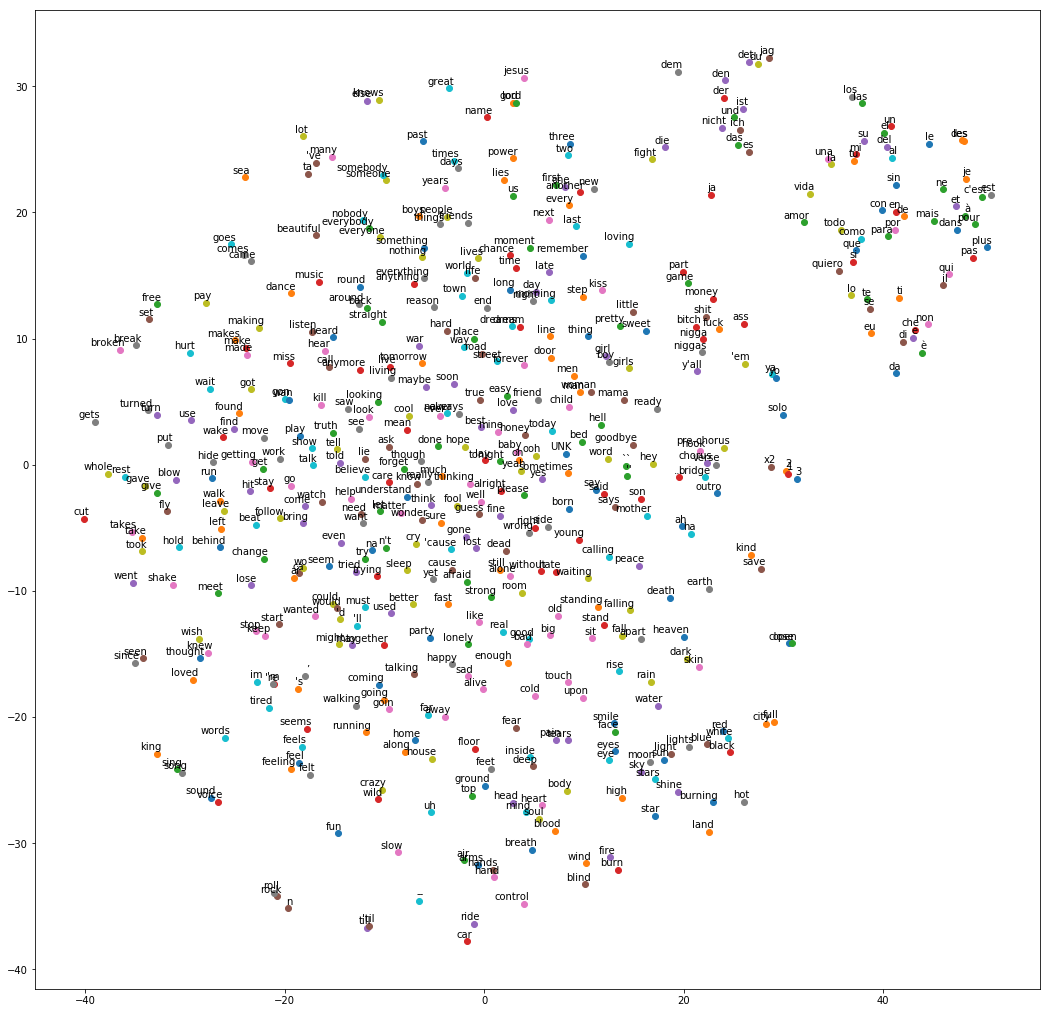

In [23]:
try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    from tempfile import gettempdir

    tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)